In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/Frozen_Dessert_Production.csv', 
                 parse_dates=True,
                 index_col='DATE')

In [3]:
df.columns = ['Production']

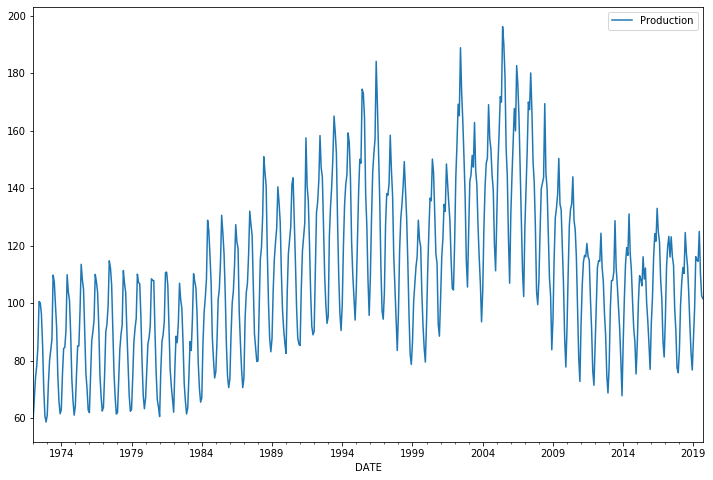

In [4]:
df.plot(figsize=(12, 8))

In [5]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [6]:
len(df)

573

In [7]:
test_size = 18
length = 12

In [8]:
test_ind = len(df) - test_size

train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()

scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [11]:
n_features = scaled_train.shape[1]

In [12]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [13]:
generator = TimeseriesGenerator(scaled_train, scaled_train, 
                               length=length, batch_size=1)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [15]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(length, n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

In [16]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, 
                               length=length, batch_size=1)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [18]:
model.fit_generator(generator, epochs=20, 
                    validation_data= validation_generator,
                    callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 543 steps, validate for 6 steps
Epoch 1/20
543/543 [==============================] - 4s 8ms/step - loss: 0.0193 - val_loss: 0.0095
Epoch 2/20
543/543 [==============================] - 4s 7ms/step - loss: 0.0084 - val_loss: 0.0022
Epoch 3/20
543/543 [==============================] - 3s 6ms/step - loss: 0.0054 - val_loss: 0.0063
Epoch 4/20
543/543 [==============================] - 4s 7ms/step - loss: 0.0045 - val_loss: 0.0035


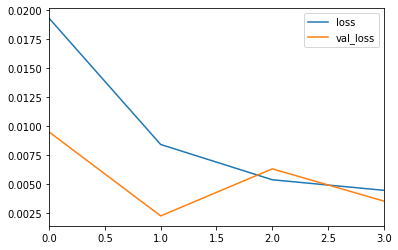

In [19]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [20]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [21]:
true_predictions = scaler.inverse_transform(test_predictions)

In [22]:
test['Predictions'] = true_predictions

/Users/nathzi1505/Desktop/Private/Online-Courses/TF_2.0/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


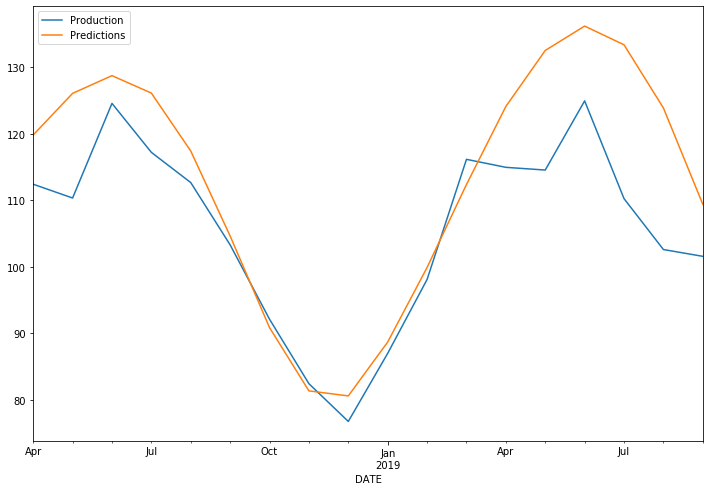

In [23]:
test.plot(figsize=(12, 8))

In [24]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test['Production'], test['Predictions']) ** 0.5 

10.657876718075336